# pyHS2MF6: Create Spatial Mapping for Coupling

The goal of this notebook is to use shapefiles that provide a description of the coupled model including GW model, 2D cell Id by cell polygon, buffered RCHRES areas, and PERLND areas. The HSPF regions (RCHRES and PERLND) are intersected with 2D model grid to provide model cell areas in each defined RCHRES and PERLND.

Create three mapping dictionaries and save these to pickle files. These pickle files/mapping dictionaries provide inputs to the coupled model. The three mapping dictionaries are:

1. RCHRES: buffered RCHRES areas are mapped on to or interesected with the GW model, 2D grid. Areas of each model cell within the buffered RCHRES areas are calculated. This dictionary has TargID as key with a list, RL, of values.
    - RL[0]: (int) number of exit that goes to GW
    - RL[1]: (float) total area for buffered RCHRES segment
    - RL[2]: (pd.DataFrame) 
        - index is 2D, Cell ID, 1-based
        - 4 columns
            - "iuzno" which is the cell id for the uzf package, 1-based
            - "TopActive" which is the top active layer, 1-based
            - "SArea_m2" which holds the area of the cell for the Cell ID within the buffered RCHRES segment
            - "Weight" which holds the weight factor for that cell. Needs to be >0 and <= 100.0
2. PERLND: pervious land areas are mapped on to or intersected with the GW model, 2D grid. Areas of each model cell within the specified PERLND area are calculated. This dictionary has TargID as key with a list, PL, of values.
    - PL[0]: (float) total area for PERLND region
    - PL[1]: (pd.DataFrame)
        - index is 2D, Cell ID, 1-based
        - 4 columns
            - "iuzno" which is the cell id for the uzf package, 1-based
            - "TopActive" which is the top active layer, 1-based
            - "SArea_m2" which holds the area of the cell for the Cell ID within the PERLND area
            - "Weight" which holds the weight factor for that cell. Needs to be >0 and <= 100.0
3.  Springs: springs which are represented with drain cells in the MODFLOW model are identified in this dictionary. The key is the TargID. Values are a list with a sublist for each drain cell, SL.
    - SL[0]: boundary name
    - SL[1]: NCPL, cell ID, 1-based
    - SL[2]: "TopActive" top active layer (this is the remainder of the cell id), 1-based
    - SL[3]: "SArea_m2" which holds the area of the cell for the Cell ID within the PERLND area

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon
import pickle

In [3]:
import flopy

In [4]:
MF6_Dir = r'C:\Repositories\pyHS2MF6\example_models\standalone\MF6'
MF6_Root = "DC_MF6"

In [5]:
OUT_DIR = r'C:\Repositories\pyHS2MF6\example_models\coupled'

In [6]:
BReach_shp = r'C:\Repositories\pyHS2MF6\example_models\gis_files\Buffered_Reaches_100m.shp'
SHP_MGRID = r'C:\Repositories\pyHS2MF6\example_models\gis_files\cpMGridUzfNo.shp'

**Assume**: The stream reaches are represented by buffered polygons that are clipped so that are non-overlapping. In addition, the model grid shapefile contains the iuzno and CellID and top active layer for every 2D cell.

In [7]:
NewHdrs = [ "CellID", #0 1-based cell ID
            "iuzno", #1
            "TopActive", #2
            "SArea_m2", #3
            "Weight", #4
          ]

## Load the Model

In [8]:
mf6_sim = flopy.mf6.MFSimulation.load( MF6_Root, 'mf6', 'mf6', MF6_Dir )

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package uzf...
    loading package ic...
    loading package gnc...
    loading package sto...
    loading package npf...
    loading package ghb...
    loading package chd...
    loading package drn...
    loading package oc...
    loading package riv...
    loading package rch...
  loading ims package dc_mf6...


In [9]:
mf6 = mf6_sim.get_model( MF6_Root.lower() )

In [10]:
mf6.package_names

['disv',
 'uzf_ts',
 'uzf_obs',
 'uzf',
 'ic',
 'gnc',
 'sto',
 'npf',
 'ghb_obs',
 'ghb',
 'chd_obs',
 'chd',
 'drn_obs',
 'drn',
 'oc',
 'riv_ts',
 'riv_obs',
 'riv',
 'rch_ts',
 'rch_obs',
 'rch']

## Load Shapefiles and Set CRS

In [11]:
BReaches = gpd.read_file( BReach_shp )

In [12]:
gpd_Grid2D = gpd.read_file( SHP_MGRID )

### Extensions and Additions for Calculating Weights

Add an area field to the grid GeoDataFrame

In [13]:
gpd_Grid2D["CellArea_m2"] = gpd_Grid2D["geometry"].area 

Create a dictionary to set our weights by hydrologic soil type

In [14]:
HSMapDict = { 'A' : 100.0,
              'B' : 10.0,
              'C' : 1.0,
              'D' : 0.1, }

Next make a custom function to do the mapping with apply because want to take into account the value for the existence of Fort Terrett outcrop

In [15]:
def setWeights( HSoil, mapDict ):
    """Custom function to set the weight based on hydrologic soil type
    
    Args:
        HSoil (str): hydrologic soil type. One of 'A', 'B', 'C', 'D'
    """
    if HSoil in mapDict.keys():
        cWeight = mapDict[HSoil]
    else:
        cWeight = 0.0
    # end if
    return cWeight

Apply the mapping to calculate a weight field.

In [16]:
gpd_Grid2D[NewHdrs[4]] = gpd_Grid2D.apply( lambda row: setWeights( row['HSoil'], HSMapDict ), 
                                             axis=1 )

In [17]:
gpd_Grid2D[NewHdrs[4]] = np.where( gpd_Grid2D["FtTerrOut"] == 1, 0.0, gpd_Grid2D[NewHdrs[4]] )

The grid file has CellID as 1-based.

In [18]:
ProjCRS = gpd_Grid2D.crs

In [19]:
V1Cols = list( gpd_Grid2D.columns )
V1Cols.remove("geometry")
display( HTML( gpd_Grid2D[V1Cols].head().to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight
0,1,1,-1,D,0,1,1000000.0,0.1
1,2,1,-1,D,0,1,1000000.0,0.1
2,3,1,-1,D,0,1,1000000.0,0.1
3,4,1,-1,D,0,1,1000000.0,0.1
4,5,1,1,D,0,1,1000000.0,0.1


In [20]:
display( HTML( gpd_Grid2D.describe().to_html() ) )

,CellID,TopAct,iuzno,FtTerrOut,HRU,CellArea_m2,Weight
count,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000
mean,6174.000000,3.414919,5389.536325,0.037661,7.201587,41633.658480,18.647882
std,3564.416221,1.157294,3522.120390,0.190383,3.748419,110665.319566,38.842187
min,1.000000,-1.000000,-1.000000,0.000000,-1.000000,3906.250000,0.000000
25%,3087.500000,3.000000,2276.500000,0.000000,4.000000,15625.000000,0.100000
50%,6174.000000,3.000000,5363.000000,0.000000,8.000000,15625.000000,0.100000
75%,9260.500000,4.000000,8449.500000,0.000000,10.000000,62500.000000,0.100000
max,12347.000000,6.000000,11536.000000,1.000000,12.000000,1000000.000000,100.000000


### Reaches

Look at the reaches in more detail

In [21]:
V1Cols = list( BReaches.columns )
V1Cols.remove("geometry")
display( HTML( BReaches[V1Cols].to_html() ) )

,Id,TargId,GWExit,LName,RLength
0,1,R001,2,Upper Dolan Creek,10242.027966
1,2,R002,2,Upper Central,13804.821259
2,3,R003,2,Lower Central,5878.525280
3,4,R004,2,Lower,7254.425563
4,5,R005,0,Dolan Springs,1745.430893


In [22]:
list( BReaches.columns )

['Id', 'TargId', 'GWExit', 'LName', 'RLength', 'geometry']

In [23]:
RGWExitList = BReaches['GWExit'].tolist()
RGWExitList

[2, 2, 2, 2, 0]

In [24]:
RTargIdList = BReaches['TargId'].tolist()
RTargIdList

['R001', 'R002', 'R003', 'R004', 'R005']

## Create Intersections and Mappings

Need a series of mappings that relate specific MODFLOW 2D grid cells to specific HSPF targets.

Mappings:

1. Grid cells to river valley by RCHRES ID
2. Grid cells to subbasins by subbasin ID

Need to be able to calculate total areas in each region

### Buffered Reaches

In [25]:
AllGridRchs = gpd.overlay( BReaches, gpd_Grid2D, how='intersection' )

In [26]:
V1Cols = list( AllGridRchs.columns )
V1Cols.remove("geometry")
display( HTML( AllGridRchs[V1Cols].head().to_html() ) )

,Id,TargId,GWExit,LName,RLength,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight
0,1,R001,2,Upper Dolan Creek,10242.027966,850,3,810,A,0,3,15625.0,100.0
1,1,R001,2,Upper Dolan Creek,10242.027966,851,3,811,A,0,3,15625.0,100.0
2,1,R001,2,Upper Dolan Creek,10242.027966,852,3,812,A,0,1,15625.0,100.0
3,1,R001,2,Upper Dolan Creek,10242.027966,853,3,813,A,0,3,15625.0,100.0
4,1,R001,2,Upper Dolan Creek,10242.027966,854,3,814,A,0,2,15625.0,100.0


Calculate the area of the interesected model cells

In [27]:
AllGridRchs["IntArea_m2"] = AllGridRchs["geometry"].area

Now split into separate DataFrames by reach

In [28]:
Rch1Grd = AllGridRchs[ ( AllGridRchs["TargId"] == "R001" ) & ( AllGridRchs['iuzno'] > 0 ) ].copy()
Rch2Grd = AllGridRchs[ ( AllGridRchs["TargId"] == "R002" ) & ( AllGridRchs['iuzno'] > 0 ) ].copy()
Rch3Grd = AllGridRchs[ ( AllGridRchs["TargId"] == "R003" ) & ( AllGridRchs['iuzno'] > 0 ) ].copy()
Rch4Grd = AllGridRchs[ ( AllGridRchs["TargId"] == "R004" ) & ( AllGridRchs['iuzno'] > 0 ) ].copy()
Rch5Grd = AllGridRchs[ ( AllGridRchs["TargId"] == "R005" ) & ( AllGridRchs['iuzno'] > 0 ) ].copy()

Extract the 2D Cell ID for each reach and go through these lists and enforce that they be unique

In [29]:
Rch1CellID = sorted( Rch1Grd['CellID'].unique() )
len(Rch1CellID)

247

In [30]:
Rch1CellID[:5]

[850, 851, 852, 853, 854]

In [31]:
Rch2CellID = sorted( Rch2Grd['CellID'].unique() )
Rch3CellID = sorted( Rch3Grd['CellID'].unique() )
Rch4CellID = sorted( Rch4Grd['CellID'].unique() )
Rch5CellID = sorted( Rch5Grd['CellID'].unique() )

Make sure that the CellIDs are unique to one reach. We want to use the entire cell area allocated to a single reach

In [32]:
CellsIn4and5 = set( Rch4CellID ) & set( Rch5CellID )
len(CellsIn4and5)

6

In [33]:
CellsIn4and5

{11133, 11136, 11137, 11142, 11144, 11717}

In [34]:
NumRch5 = len( Rch5CellID )
NumRch4 = len( Rch4CellID )
NumRch4, NumRch5

(510, 127)

In [35]:
for cL in CellsIn4and5:
    Rch4CellID.remove(cL)
# end for
NumRch4 = len( Rch4CellID )
NumRch4

504

In [36]:
CellsIn3and4 = set( Rch3CellID ) & set( Rch4CellID )
len(CellsIn3and4)

3

In [37]:
NumRch3 = len( Rch3CellID )
NumRch3

140

In [38]:
for cL in CellsIn3and4:
    Rch3CellID.remove(cL)
# end for
NumRch3 = len( Rch3CellID )
NumRch3

137

In [39]:
CellsIn2and3 = set( Rch2CellID ) & set( Rch3CellID )
len(CellsIn2and3)

4

In [40]:
NumRch2 = len( Rch2CellID )
NumRch2

322

In [41]:
for cL in CellsIn2and3:
    Rch2CellID.remove(cL)
# end for
NumRch2 = len( Rch2CellID )
NumRch2

318

In [42]:
CellsIn1and2 = set( Rch1CellID ) & set( Rch2CellID )
len(CellsIn1and2)

3

In [43]:
NumRch1 = len( Rch1CellID )
NumRch1

247

In [44]:
for cL in CellsIn1and2:
    Rch1CellID.remove(cL)
# end for
NumRch1 = len( Rch1CellID )
NumRch1

244

In [45]:
Rch1Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(Rch1CellID)].copy()
len(Rch1Grd)

244

In [46]:
V1Cols = list( Rch1Grd.columns )
V1Cols.remove("geometry")
display( HTML( Rch1Grd[V1Cols].head().to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight
849,850,3,810,A,0,3,15625.0,100.0
850,851,3,811,A,0,3,15625.0,100.0
851,852,3,812,A,0,1,15625.0,100.0
852,853,3,813,A,0,3,15625.0,100.0
853,854,3,814,A,0,2,15625.0,100.0


In [47]:
Rch2Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(Rch2CellID)].copy()
len(Rch2Grd)

318

In [48]:
Rch3Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(Rch3CellID)].copy()
len(Rch3Grd)

137

In [49]:
Rch4Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(Rch4CellID)].copy()
len(Rch4Grd)

504

In [50]:
Rch5Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(Rch5CellID)].copy()
len(Rch5Grd)

127

In [51]:
NumURG1 = len( Rch1Grd["CellID"].unique() )
NumURG2 = len( Rch2Grd["CellID"].unique() )
NumURG3 = len( Rch3Grd["CellID"].unique() )
NumURG4 = len( Rch4Grd["CellID"].unique() )
NumURG5 = len( Rch5Grd["CellID"].unique() )

In [52]:
NumRch1, NumURG1

(244, 244)

In [53]:
NumRch2, NumURG2

(318, 318)

In [54]:
NumRch3, NumURG3

(137, 137)

In [55]:
NumRch4, NumURG4

(504, 504)

In [56]:
NumRch5, NumURG5

(127, 127)

At this point, have GeoDataFrames for each reach in the HSPF model with a unique collection of CellIDs.

Now make the regular DataFrames that are needed for the dictionaries with the appropriate column formats.

In [57]:
dfIndexer = np.array( Rch1Grd["CellID"].tolist(), dtype=np.int32 )
DataR1Dict = { NewHdrs[1] : np.array( Rch1Grd["iuzno"].tolist(), dtype=np.int32 ),
               NewHdrs[2] : np.array( Rch1Grd["TopAct"].tolist(), dtype=np.int32 ),
               NewHdrs[3] : np.array( Rch1Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
               NewHdrs[4] : np.array( Rch1Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Rch1DF = pd.DataFrame( index=dfIndexer, data=DataR1Dict )

In [58]:
dfIndexer = np.array( Rch2Grd["CellID"].tolist(), dtype=np.int32 )
DataR2Dict = { NewHdrs[1] : np.array( Rch2Grd["iuzno"].tolist(), dtype=np.int32 ),
               NewHdrs[2] : np.array( Rch2Grd["TopAct"].tolist(), dtype=np.int32 ),
               NewHdrs[3] : np.array( Rch2Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
               NewHdrs[4] : np.array( Rch2Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Rch2DF = pd.DataFrame( index=dfIndexer, data=DataR2Dict )

In [59]:
dfIndexer = np.array( Rch3Grd["CellID"].tolist(), dtype=np.int32 )
DataR3Dict = { NewHdrs[1] : np.array( Rch3Grd["iuzno"].tolist(), dtype=np.int32 ),
               NewHdrs[2] : np.array( Rch3Grd["TopAct"].tolist(), dtype=np.int32 ),
               NewHdrs[3] : np.array( Rch3Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
               NewHdrs[4] : np.array( Rch3Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Rch3DF = pd.DataFrame( index=dfIndexer, data=DataR3Dict )

In [60]:
dfIndexer = np.array( Rch4Grd["CellID"].tolist(), dtype=np.int32 )
DataR4Dict = { NewHdrs[1] : np.array( Rch4Grd["iuzno"].tolist(), dtype=np.int32 ),
               NewHdrs[2] : np.array( Rch4Grd["TopAct"].tolist(), dtype=np.int32 ),
               NewHdrs[3] : np.array( Rch4Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
               NewHdrs[4] : np.array( Rch4Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Rch4DF = pd.DataFrame( index=dfIndexer, data=DataR4Dict )

In [61]:
dfIndexer = np.array( Rch5Grd["CellID"].tolist(), dtype=np.int32 )
DataR5Dict = { NewHdrs[1] : np.array( Rch5Grd["iuzno"].tolist(), dtype=np.int32 ),
               NewHdrs[2] : np.array( Rch5Grd["TopAct"].tolist(), dtype=np.int32 ),
               NewHdrs[3] : np.array( Rch5Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
               NewHdrs[4] : np.array( Rch5Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Rch5DF = pd.DataFrame( index=dfIndexer, data=DataR5Dict )

In [62]:
CalcR1Area = Rch1DF[NewHdrs[3]].sum()
CalcR1Area

3812500.0

In [63]:
CalcR2Area = Rch2DF[NewHdrs[3]].sum()
CalcR2Area

4968750.0

In [64]:
CalcR3Area = Rch3DF[NewHdrs[3]].sum()
CalcR3Area

2105468.75

In [65]:
CalcR4Area = Rch4DF[NewHdrs[3]].sum()
CalcR4Area

1992187.5

In [66]:
CalcR5Area = Rch5DF[NewHdrs[3]].sum()
CalcR5Area

496093.75

In [67]:
Rch1DF.sort_index( inplace=True )
Rch2DF.sort_index( inplace=True )
Rch3DF.sort_index( inplace=True )
Rch4DF.sort_index( inplace=True )
Rch5DF.sort_index( inplace=True )

In [68]:
display( HTML( Rch1DF.head().to_html() ))

,iuzno,TopActive,SArea_m2,Weight
850,810,3,15625.0,100.0
851,811,3,15625.0,100.0
852,812,3,15625.0,100.0
853,813,3,15625.0,100.0
854,814,3,15625.0,100.0


In [69]:
display( HTML( Rch5DF.head().to_html() ))

,iuzno,TopActive,SArea_m2,Weight
11133,10503,6,3906.25,0.0
11136,10506,6,3906.25,0.0
11137,10507,6,3906.25,0.0
11140,10510,6,3906.25,0.0
11142,10512,6,3906.25,0.0


Now output our RCHRES dictionary with mapping to the stream valley area and MODFLOW 6 cells within each area

In [70]:
RTargIdList

['R001', 'R002', 'R003', 'R004', 'R005']

In [71]:
WS_RCHRES = dict()
WS_RCHRES[RTargIdList[0]] = [ RGWExitList[0], CalcR1Area, Rch1DF ]
WS_RCHRES[RTargIdList[1]] = [ RGWExitList[1], CalcR2Area, Rch2DF ]
WS_RCHRES[RTargIdList[2]] = [ RGWExitList[2], CalcR3Area, Rch3DF ]
WS_RCHRES[RTargIdList[3]] = [ RGWExitList[3], CalcR4Area, Rch4DF ]
WS_RCHRES[RTargIdList[4]] = [ RGWExitList[4], CalcR5Area, Rch5DF ]

In [72]:
list(WS_RCHRES.keys())

['R001', 'R002', 'R003', 'R004', 'R005']

In [73]:
WS_RCHRES['R005']

[0,
 496093.75,
        iuzno  TopActive  SArea_m2  Weight
 11133  10503          6   3906.25     0.0
 11136  10506          6   3906.25     0.0
 11137  10507          6   3906.25     0.0
 11140  10510          6   3906.25     0.0
 11142  10512          6   3906.25     0.0
 ...      ...        ...       ...     ...
 12273  11477          6   3906.25   100.0
 12274  11478          6   3906.25   100.0
 12275  11479          6   3906.25   100.0
 12276  11480          5   3906.25     0.1
 12277  11481          5   3906.25     0.1
 
 [127 rows x 4 columns]]

In [74]:
OutFile = "cpWS_Rchres.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( WS_RCHRES, OP, pickle.HIGHEST_PROTOCOL )

#### RCHRES Dictionary Shapefile

Create a GeoDataFrame that combines and extends all of our dictionary entries for use in plotting and analysis of model results

In [75]:
Rch1DF[NewHdrs[0]] = Rch1DF.index

In [76]:
display( HTML( Rch1DF.head().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID
850,810,3,15625.0,100.0,850
851,811,3,15625.0,100.0,851
852,812,3,15625.0,100.0,852
853,813,3,15625.0,100.0,853
854,814,3,15625.0,100.0,854


In [77]:
Rch2DF[NewHdrs[0]] = Rch2DF.index
Rch3DF[NewHdrs[0]] = Rch3DF.index
Rch4DF[NewHdrs[0]] = Rch4DF.index
Rch5DF[NewHdrs[0]] = Rch5DF.index

In [78]:
Rch1DF['TargId'] = RTargIdList[0]
Rch2DF['TargId'] = RTargIdList[1]
Rch3DF['TargId'] = RTargIdList[2]
Rch4DF['TargId'] = RTargIdList[3]
Rch5DF['TargId'] = RTargIdList[4]

Calculate the combined cell area and hydrologic soil weight for each cell. This is the same algorithm as used within the coupled code to distribute losses from RCHRES to groundwater through the specified RCHRES exit.

In [79]:
CCombWeight = lambda TotA, TotW, cA, cW: 0.5 * ( ( cA / TotA ) + ( cW / TotW ) )

In [80]:
Rch1TotWght = Rch1DF[NewHdrs[4]].sum()
Rch2TotWght = Rch2DF[NewHdrs[4]].sum()
Rch3TotWght = Rch3DF[NewHdrs[4]].sum()
Rch4TotWght = Rch4DF[NewHdrs[4]].sum()
Rch5TotWght = Rch5DF[NewHdrs[4]].sum()
Rch1TotWght, Rch5TotWght 

(22802.5, 2702.1)

In [81]:
Rch1DF["CombWeight"] = Rch1DF.apply( lambda row: CCombWeight( CalcR1Area, Rch1TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [82]:
Rch2DF["CombWeight"] = Rch2DF.apply( lambda row: CCombWeight( CalcR2Area, Rch2TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [83]:
Rch3DF["CombWeight"] = Rch3DF.apply( lambda row: CCombWeight( CalcR3Area, Rch3TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [84]:
Rch4DF["CombWeight"] = Rch4DF.apply( lambda row: CCombWeight( CalcR4Area, Rch4TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [85]:
Rch5DF["CombWeight"] = Rch5DF.apply( lambda row: CCombWeight( CalcR5Area, Rch5TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

Combined or concatenate to make one DataFrame

In [86]:
CCList = [ Rch1DF, Rch2DF, Rch3DF, Rch4DF, Rch5DF ]

In [87]:
AllRchDF = pd.concat( CCList, ignore_index=True )

In [88]:
display( HTML( AllRchDF.head().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,TargId,CombWeight
0,810,3,15625.0,100.0,850,R001,0.004242
1,811,3,15625.0,100.0,851,R001,0.004242
2,812,3,15625.0,100.0,852,R001,0.004242
3,813,3,15625.0,100.0,853,R001,0.004242
4,814,3,15625.0,100.0,854,R001,0.004242


In [89]:
display( HTML( AllRchDF.tail().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,TargId,CombWeight
1325,11477,6,3906.25,100.0,12273,R005,0.022441
1326,11478,6,3906.25,100.0,12274,R005,0.022441
1327,11479,6,3906.25,100.0,12275,R005,0.022441
1328,11480,5,3906.25,0.1,12276,R005,0.003956
1329,11481,5,3906.25,0.1,12277,R005,0.003956


In [90]:
AllRchDF[AllRchDF['TargId'] == 'R005']['CombWeight'].sum()

1.0

In [91]:
AllRchDF['CombWeight'].sum()

5.0

Get the geometry objects from the 2D grid so that can make a GeoDataFrame and save to a shapefile

In [92]:
ARCellIDs = AllRchDF[NewHdrs[0]].tolist()

In [93]:
ARCellGeom = list()

In [94]:
for jJ in ARCellIDs:
    gInd = gpd_Grid2D[gpd_Grid2D[NewHdrs[0]] == jJ].index[0]
    ARCellGeom.append( gpd_Grid2D.at[gInd, "geometry"] )
# end for

In [95]:
gpd_ReachMap = gpd.GeoDataFrame( AllRchDF, geometry=ARCellGeom )
gpd_ReachMap.crs = ProjCRS

<AxesSubplot: >

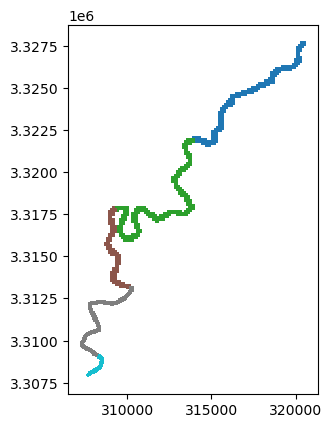

In [96]:
gpd_ReachMap.plot( column='TargId' )

In [97]:
display( HTML( gpd_ReachMap.describe().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,CombWeight
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,6475.620301,4.497744,10056.390977,75.728045,6708.475188,0.003759
std,3074.166683,1.040379,5854.357359,42.872818,3267.221915,0.003187
min,810.000000,2.000000,3906.250000,0.000000,850.000000,0.000980
25%,4261.250000,4.000000,3906.250000,100.000000,4345.250000,0.002459
50%,6970.500000,5.000000,15625.000000,100.000000,7121.500000,0.003296
75%,9540.750000,5.000000,15625.000000,100.000000,9944.750000,0.004242
max,11481.000000,6.000000,15625.000000,100.000000,12277.000000,0.022441


In [98]:
OutFile = "cpRCHRESMap.shp"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
gpd_ReachMap.to_file( OutFP )

### HRUs

In [99]:
V1Cols = list( gpd_Grid2D.columns )
V1Cols.remove("geometry")
display( HTML( gpd_Grid2D[V1Cols].head().to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight
0,1,1,-1,D,0,1,1000000.0,0.1
1,2,1,-1,D,0,1,1000000.0,0.1
2,3,1,-1,D,0,1,1000000.0,0.1
3,4,1,-1,D,0,1,1000000.0,0.1
4,5,1,1,D,0,1,1000000.0,0.1


In [100]:
display( HTML( gpd_Grid2D.describe().to_html() ) )

,CellID,TopAct,iuzno,FtTerrOut,HRU,CellArea_m2,Weight
count,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000
mean,6174.000000,3.414919,5389.536325,0.037661,7.201587,41633.658480,18.647882
std,3564.416221,1.157294,3522.120390,0.190383,3.748419,110665.319566,38.842187
min,1.000000,-1.000000,-1.000000,0.000000,-1.000000,3906.250000,0.000000
25%,3087.500000,3.000000,2276.500000,0.000000,4.000000,15625.000000,0.100000
50%,6174.000000,3.000000,5363.000000,0.000000,8.000000,15625.000000,0.100000
75%,9260.500000,4.000000,8449.500000,0.000000,10.000000,62500.000000,0.100000
max,12347.000000,6.000000,11536.000000,1.000000,12.000000,1000000.000000,100.000000


Go through the 2D grid and determine our list of unique CellIDs for each HRU. CellIDs where iuzno < 1, TopAct < 1, or where the CellID is already used for one of the defined Reach areas should be skipped or dropped.

In [101]:
PTargIdList = [ "P{:03d}".format( x ) for x in range(1, 13, 1) ]
PTargIdList

['P001',
 'P002',
 'P003',
 'P004',
 'P005',
 'P006',
 'P007',
 'P008',
 'P009',
 'P010',
 'P011',
 'P012']

In [102]:
HRU_1_CIDs = list()
HRU_2_CIDs = list()
HRU_3_CIDs = list()
HRU_4_CIDs = list()
HRU_5_CIDs = list()
HRU_6_CIDs = list()
HRU_7_CIDs = list()
HRU_8_CIDs = list()
HRU_9_CIDs = list()
HRU_10_CIDs = list()
HRU_11_CIDs = list()
HRU_12_CIDs = list()

In [103]:
NumGC = len( gpd_Grid2D )
NumGC

12347

In [104]:
for jJ in range(NumGC):
    cRow = gpd_Grid2D.loc[jJ]
    topA = int( cRow['TopAct'] )
    if topA < 1:
        continue
    iuzno = int( cRow['iuzno'] )
    if iuzno < 1:
        continue
    cHRU = int( cRow['HRU'] )
    if cHRU < 1:
        continue
    # get the cell id
    cCId = int( cRow['CellID'] )
    # now check if already in one of the river reaches
    if cCId in Rch1CellID:
        continue
    elif cCId in Rch2CellID:
        continue
    elif cCId in Rch3CellID:
        continue
    elif cCId in Rch4CellID:
        continue
    elif cCId in Rch5CellID:
        continue
    # now can add to our list based on HRU
    if cHRU == 1:
        HRU_1_CIDs.append( cCId )
    elif cHRU == 2:
        HRU_2_CIDs.append( cCId )
    elif cHRU == 3:
        HRU_3_CIDs.append( cCId )
    elif cHRU == 4:
        HRU_4_CIDs.append( cCId )
    elif cHRU == 5:
        HRU_5_CIDs.append( cCId )
    elif cHRU == 6:
        HRU_6_CIDs.append( cCId )
    elif cHRU == 7:
        HRU_7_CIDs.append( cCId )
    elif cHRU == 8:
        HRU_8_CIDs.append( cCId )
    elif cHRU == 9:
        HRU_9_CIDs.append( cCId )
    elif cHRU == 10:
        HRU_10_CIDs.append( cCId )
    elif cHRU == 11:
        HRU_11_CIDs.append( cCId )
    elif cHRU == 12:
        HRU_12_CIDs.append( cCId )
    # end if
# end for

In [105]:
NumH1 = len( HRU_1_CIDs )
NumH2 = len( HRU_2_CIDs )
NumH3 = len( HRU_3_CIDs )
NumH4 = len( HRU_4_CIDs )
NumH5 = len( HRU_5_CIDs )
NumH6 = len( HRU_6_CIDs )
NumH7 = len( HRU_7_CIDs )
NumH8 = len( HRU_8_CIDs )
NumH9 = len( HRU_9_CIDs )
NumH10 = len( HRU_10_CIDs )
NumH11 = len( HRU_11_CIDs )
NumH12 = len( HRU_12_CIDs )
NumH1, NumH2, NumH3, NumH4, NumH5, NumH6, NumH7, NumH8, NumH9, NumH10, NumH11, NumH12

(520, 791, 437, 579, 415, 476, 1110, 1551, 738, 1181, 1010, 1398)

In [106]:
TotalHRUIds = NumH1 + NumH2 + NumH3 + NumH4 + NumH5 + NumH6 + NumH7 + NumH8 + NumH9 + NumH10 + NumH11 + NumH12
TotalHRUIds

10206

In [107]:
TotRivers = len( gpd_ReachMap )
TotRivers

1330

In [108]:
TotalHRUIds + TotRivers

11536

In [109]:
uzf = mf6.get_package( 'uzf' )

In [110]:
numuzf = uzf.nuzfcells.get_data()
numuzf

11077

In [111]:
HRU1Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_1_CIDs)].copy()
HRU2Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_2_CIDs)].copy()
HRU3Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_3_CIDs)].copy()
HRU4Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_4_CIDs)].copy()
HRU5Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_5_CIDs)].copy()
HRU6Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_6_CIDs)].copy()
HRU7Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_7_CIDs)].copy()
HRU8Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_8_CIDs)].copy()
HRU9Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_9_CIDs)].copy()
HRU10Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_10_CIDs)].copy()
HRU11Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_11_CIDs)].copy()
HRU12Grd = gpd_Grid2D[gpd_Grid2D['CellID'].isin(HRU_12_CIDs)].copy()

In [112]:
NumUSG1 = len( HRU1Grd["CellID"].unique() )
NumUSG2 = len( HRU2Grd["CellID"].unique() )
NumUSG3 = len( HRU3Grd["CellID"].unique() )
NumUSG4 = len( HRU4Grd["CellID"].unique() )
NumUSG5 = len( HRU5Grd["CellID"].unique() )
NumUSG6 = len( HRU6Grd["CellID"].unique() )
NumUSG7 = len( HRU7Grd["CellID"].unique() )
NumUSG8 = len( HRU8Grd["CellID"].unique() )
NumUSG9 = len( HRU9Grd["CellID"].unique() )
NumUSG10 = len( HRU10Grd["CellID"].unique() )
NumUSG11 = len( HRU11Grd["CellID"].unique() )
NumUSG12 = len( HRU12Grd["CellID"].unique() )

In [113]:
NumUSG1, NumH1

(520, 520)

In [114]:
NumUSG2, NumH2

(791, 791)

In [115]:
NumUSG3, NumH3

(437, 437)

In [116]:
NumUSG4, NumH4

(579, 579)

In [117]:
NumUSG5, NumH5

(415, 415)

In [118]:
NumUSG6, NumH6

(476, 476)

In [119]:
NumUSG7, NumH7

(1110, 1110)

In [120]:
NumUSG8, NumH8

(1551, 1551)

In [121]:
NumUSG9, NumH9

(738, 738)

In [122]:
NumUSG10, NumH10

(1181, 1181)

In [123]:
NumUSG11, NumH11

(1010, 1010)

In [124]:
NumUSG12, NumH12

(1398, 1398)

In [125]:
dfIndexer = np.array( HRU1Grd["CellID"].tolist(), dtype=np.int32 )
DataS1Dict = {  NewHdrs[1] : np.array( HRU1Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU1Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU1Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU1Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru1DF = pd.DataFrame( index=dfIndexer, data=DataS1Dict )

In [126]:
dfIndexer = np.array( HRU2Grd["CellID"].tolist(), dtype=np.int32 )
DataS2Dict = {  NewHdrs[1] : np.array( HRU2Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU2Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU2Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU2Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru2DF = pd.DataFrame( index=dfIndexer, data=DataS2Dict )

In [127]:
dfIndexer = np.array( HRU3Grd["CellID"].tolist(), dtype=np.int32 )
DataS3Dict = {  NewHdrs[1] : np.array( HRU3Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU3Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU3Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU3Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru3DF = pd.DataFrame( index=dfIndexer, data=DataS3Dict )

In [128]:
dfIndexer = np.array( HRU4Grd["CellID"].tolist(), dtype=np.int32 )
DataS4Dict = {  NewHdrs[1] : np.array( HRU4Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU4Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU4Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU4Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru4DF = pd.DataFrame( index=dfIndexer, data=DataS4Dict )

In [129]:
dfIndexer = np.array( HRU5Grd["CellID"].tolist(), dtype=np.int32 )
DataS5Dict = {  NewHdrs[1] : np.array( HRU5Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU5Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU5Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU5Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru5DF = pd.DataFrame( index=dfIndexer, data=DataS5Dict )

In [130]:
dfIndexer = np.array( HRU6Grd["CellID"].tolist(), dtype=np.int32 )
DataS6Dict = {  NewHdrs[1] : np.array( HRU6Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU6Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU6Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU6Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru6DF = pd.DataFrame( index=dfIndexer, data=DataS6Dict )

In [131]:
dfIndexer = np.array( HRU7Grd["CellID"].tolist(), dtype=np.int32 )
DataS7Dict = {  NewHdrs[1] : np.array( HRU7Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU7Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU7Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU7Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru7DF = pd.DataFrame( index=dfIndexer, data=DataS7Dict )

In [132]:
dfIndexer = np.array( HRU8Grd["CellID"].tolist(), dtype=np.int32 )
DataS8Dict = {  NewHdrs[1] : np.array( HRU8Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU8Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU8Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU8Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru8DF = pd.DataFrame( index=dfIndexer, data=DataS8Dict )

In [133]:
dfIndexer = np.array( HRU9Grd["CellID"].tolist(), dtype=np.int32 )
DataS9Dict = {  NewHdrs[1] : np.array( HRU9Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU9Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU9Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU9Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru9DF = pd.DataFrame( index=dfIndexer, data=DataS9Dict )

In [134]:
dfIndexer = np.array( HRU10Grd["CellID"].tolist(), dtype=np.int32 )
DataS10Dict = {  NewHdrs[1] : np.array( HRU10Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU10Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU10Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU10Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru10DF = pd.DataFrame( index=dfIndexer, data=DataS10Dict )

In [135]:
dfIndexer = np.array( HRU11Grd["CellID"].tolist(), dtype=np.int32 )
DataS11Dict = {  NewHdrs[1] : np.array( HRU11Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU11Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU11Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU11Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru11DF = pd.DataFrame( index=dfIndexer, data=DataS11Dict )

In [136]:
dfIndexer = np.array( HRU12Grd["CellID"].tolist(), dtype=np.int32 )
DataS12Dict = {  NewHdrs[1] : np.array( HRU12Grd["iuzno"].tolist(), dtype=np.int32 ),
                NewHdrs[2] : np.array( HRU12Grd["TopAct"].tolist(), dtype=np.int32 ),
                NewHdrs[3] : np.array( HRU12Grd["CellArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( HRU12Grd[NewHdrs[4]].tolist(), dtype=np.float64 ),
             }
Hru12DF = pd.DataFrame( index=dfIndexer, data=DataS12Dict )

In [137]:
CalcS1Area = Hru1DF[NewHdrs[3]].sum()
CalcS1Area

93578125.0

In [138]:
CalcS2Area = Hru2DF[NewHdrs[3]].sum()
CalcS2Area

43062500.0

In [139]:
CalcS3Area = Hru3DF[NewHdrs[3]].sum()
CalcS3Area

30265625.0

In [140]:
CalcS4Area = Hru4DF[NewHdrs[3]].sum()
CalcS4Area

30281250.0

In [141]:
CalcS5Area = Hru5DF[NewHdrs[3]].sum()
CalcS5Area

61750000.0

In [142]:
CalcS6Area = Hru6DF[NewHdrs[3]].sum()
CalcS6Area

19437500.0

In [143]:
CalcS7Area = Hru7DF[NewHdrs[3]].sum()
CalcS7Area

72046875.0

In [144]:
CalcS8Area = Hru8DF[NewHdrs[3]].sum()
CalcS8Area

21117187.5

In [145]:
CalcS9Area = Hru9DF[NewHdrs[3]].sum()
CalcS9Area

31500000.0

In [146]:
CalcS10Area = Hru10DF[NewHdrs[3]].sum()
CalcS10Area

9101562.5

In [147]:
CalcS11Area = Hru11DF[NewHdrs[3]].sum()
CalcS11Area

13496093.75

In [148]:
CalcS12Area = Hru12DF[NewHdrs[3]].sum()
CalcS12Area

16218750.0

In [149]:
Hru1DF.sort_index( inplace=True )
Hru2DF.sort_index( inplace=True )
Hru3DF.sort_index( inplace=True )
Hru4DF.sort_index( inplace=True )
Hru5DF.sort_index( inplace=True )
Hru6DF.sort_index( inplace=True )
Hru7DF.sort_index( inplace=True )
Hru8DF.sort_index( inplace=True )
Hru9DF.sort_index( inplace=True )
Hru10DF.sort_index( inplace=True )
Hru11DF.sort_index( inplace=True )
Hru12DF.sort_index( inplace=True )

In [150]:
display( HTML( Hru1DF.tail().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight
1772,1728,2,250000.0,0.1
1773,1729,1,250000.0,0.1
1774,1730,1,250000.0,0.1
1775,1731,2,250000.0,0.1
1776,1732,2,1000000.0,0.1


In [151]:
display( HTML( Hru10DF.tail().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight
11207,10576,3,15625.0,0.1
11213,10582,3,15625.0,0.1
11215,10584,4,15625.0,0.1
11216,10585,3,15625.0,0.1
11237,10606,4,15625.0,0.1


Output our watershed mapping dictionary which maps groundwater model cells to subbasins/pervious area segments/HRUs including the area of the model cell within the PERLND and the total area of the subbasin

In [152]:
WS_PERLND = dict()
WS_PERLND[PTargIdList[0]] = [ CalcS1Area, Hru1DF ]
WS_PERLND[PTargIdList[1]] = [ CalcS2Area, Hru2DF ]
WS_PERLND[PTargIdList[2]] = [ CalcS3Area, Hru3DF ]
WS_PERLND[PTargIdList[3]] = [ CalcS4Area, Hru4DF ]
WS_PERLND[PTargIdList[4]] = [ CalcS5Area, Hru5DF ]
WS_PERLND[PTargIdList[5]] = [ CalcS6Area, Hru6DF ]
WS_PERLND[PTargIdList[6]] = [ CalcS7Area, Hru7DF ]
WS_PERLND[PTargIdList[7]] = [ CalcS8Area, Hru8DF ]
WS_PERLND[PTargIdList[8]] = [ CalcS9Area, Hru9DF ]
WS_PERLND[PTargIdList[9]] = [ CalcS10Area, Hru10DF ]
WS_PERLND[PTargIdList[10]] = [ CalcS11Area, Hru11DF ]
WS_PERLND[PTargIdList[11]] = [ CalcS12Area, Hru12DF ]

In [153]:
OutFile = "cpWS_Perlnd.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( WS_PERLND, OP, pickle.HIGHEST_PROTOCOL )

#### PERLND Dictionary Shapefile

Create a GeoDataFrame that combines and extends all of our dictionary entries for use in plotting and analysis of model results

In [154]:
Hru1DF[NewHdrs[0]] = Hru1DF.index

In [155]:
display( HTML( Hru1DF.head().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID
5,1,1,1000000.0,0.1,5
6,2,1,1000000.0,0.1,6
9,3,1,1000000.0,0.1,9
10,4,1,1000000.0,0.1,10
13,5,1,1000000.0,0.1,13


In [156]:
Hru2DF[NewHdrs[0]] = Hru2DF.index
Hru3DF[NewHdrs[0]] = Hru3DF.index
Hru4DF[NewHdrs[0]] = Hru4DF.index
Hru5DF[NewHdrs[0]] = Hru5DF.index
Hru6DF[NewHdrs[0]] = Hru6DF.index
Hru7DF[NewHdrs[0]] = Hru7DF.index
Hru8DF[NewHdrs[0]] = Hru8DF.index
Hru9DF[NewHdrs[0]] = Hru9DF.index
Hru10DF[NewHdrs[0]] = Hru10DF.index
Hru11DF[NewHdrs[0]] = Hru11DF.index
Hru12DF[NewHdrs[0]] = Hru12DF.index

In [157]:
Hru1DF['TargId'] = PTargIdList[0]
Hru2DF['TargId'] = PTargIdList[1]
Hru3DF['TargId'] = PTargIdList[2]
Hru4DF['TargId'] = PTargIdList[3]
Hru5DF['TargId'] = PTargIdList[4]
Hru6DF['TargId'] = PTargIdList[5]
Hru7DF['TargId'] = PTargIdList[6]
Hru8DF['TargId'] = PTargIdList[7]
Hru9DF['TargId'] = PTargIdList[8]
Hru10DF['TargId'] = PTargIdList[9]
Hru11DF['TargId'] = PTargIdList[10]
Hru12DF['TargId'] = PTargIdList[11]

Calculate the combined cell area and hydrologic soil weight for each cell. This is the same algorithm as used within the coupled code to deep infiltration from groundwater from each HRU to specified infiltration in the MODFLOW model.

In [158]:
Hru1TotWght = Hru1DF[NewHdrs[4]].sum()
Hru2TotWght = Hru2DF[NewHdrs[4]].sum()
Hru3TotWght = Hru3DF[NewHdrs[4]].sum()
Hru4TotWght = Hru4DF[NewHdrs[4]].sum()
Hru5TotWght = Hru5DF[NewHdrs[4]].sum()
Hru6TotWght = Hru6DF[NewHdrs[4]].sum()
Hru7TotWght = Hru7DF[NewHdrs[4]].sum()
Hru8TotWght = Hru8DF[NewHdrs[4]].sum()
Hru9TotWght = Hru9DF[NewHdrs[4]].sum()
Hru10TotWght = Hru10DF[NewHdrs[4]].sum()
Hru11TotWght = Hru11DF[NewHdrs[4]].sum()
Hru12TotWght = Hru12DF[NewHdrs[4]].sum()
Hru1TotWght, Hru5TotWght 

(14353.900000000001, 8833.600000000002)

In [159]:
Hru1DF["CombWeight"] = Hru1DF.apply( lambda row: CCombWeight( CalcS1Area, Hru1TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [160]:
Hru2DF["CombWeight"] = Hru2DF.apply( lambda row: CCombWeight( CalcS2Area, Hru2TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [161]:
Hru3DF["CombWeight"] = Hru3DF.apply( lambda row: CCombWeight( CalcS3Area, Hru3TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [162]:
Hru4DF["CombWeight"] = Hru4DF.apply( lambda row: CCombWeight( CalcS4Area, Hru4TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [163]:
Hru5DF["CombWeight"] = Hru5DF.apply( lambda row: CCombWeight( CalcS5Area, Hru5TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [164]:
Hru6DF["CombWeight"] = Hru6DF.apply( lambda row: CCombWeight( CalcS6Area, Hru6TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [165]:
Hru7DF["CombWeight"] = Hru7DF.apply( lambda row: CCombWeight( CalcS7Area, Hru7TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [166]:
Hru8DF["CombWeight"] = Hru8DF.apply( lambda row: CCombWeight( CalcS8Area, Hru8TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [167]:
Hru9DF["CombWeight"] = Hru9DF.apply( lambda row: CCombWeight( CalcS9Area, Hru9TotWght, 
                                                              row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [168]:
Hru10DF["CombWeight"] = Hru10DF.apply( lambda row: CCombWeight( CalcS10Area, Hru10TotWght, 
                                                                row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [169]:
Hru11DF["CombWeight"] = Hru11DF.apply( lambda row: CCombWeight( CalcS11Area, Hru11TotWght, 
                                                                row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

In [170]:
Hru12DF["CombWeight"] = Hru12DF.apply( lambda row: CCombWeight( CalcS12Area, Hru12TotWght, 
                                                                row[NewHdrs[3]], row[NewHdrs[4]] ), axis=1 )

Combined or concatenate to make one DataFrame

In [171]:
CCList = [ Hru1DF, Hru2DF, Hru3DF, Hru4DF, Hru5DF, Hru6DF, Hru7DF, Hru8DF, Hru9DF, Hru10DF, Hru11DF, Hru12DF ]

In [172]:
AllHruDF = pd.concat( CCList, ignore_index=True )

In [173]:
display( HTML( AllHruDF.head().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,TargId,CombWeight
0,1,1,1000000.0,0.1,5,P001,0.005347
1,2,1,1000000.0,0.1,6,P001,0.005347
2,3,1,1000000.0,0.1,9,P001,0.005347
3,4,1,1000000.0,0.1,10,P001,0.005347
4,5,1,1000000.0,0.1,13,P001,0.005347


In [174]:
display( HTML( AllHruDF.tail().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,TargId,CombWeight
10201,10956,5,3906.25,100.0,11712,P012,0.004384
10202,10957,6,3906.25,100.0,11713,P012,0.004384
10203,10958,5,3906.25,0.1,11714,P012,0.000125
10204,10959,5,3906.25,100.0,11715,P012,0.004384
10205,10960,6,3906.25,100.0,11716,P012,0.004384


In [175]:
AllHruDF[AllHruDF['TargId'] == 'P005']['CombWeight'].sum()

0.9999999999999999

In [176]:
AllHruDF['CombWeight'].sum()

12.000000000000002

Get the geometry objects from the 2D grid so that can make a GeoDataFrame and save to a shapefile

In [177]:
ARCellIDs = AllHruDF[NewHdrs[0]].tolist()

In [178]:
ARCellGeom = list()

In [179]:
for jJ in ARCellIDs:
    gInd = gpd_Grid2D[gpd_Grid2D[NewHdrs[0]] == jJ].index[0]
    ARCellGeom.append( gpd_Grid2D.at[gInd, "geometry"] )
# end for

In [180]:
gpd_HruMap = gpd.GeoDataFrame( AllHruDF, geometry=ARCellGeom )
gpd_HruMap.crs = ProjCRS

<AxesSubplot: >

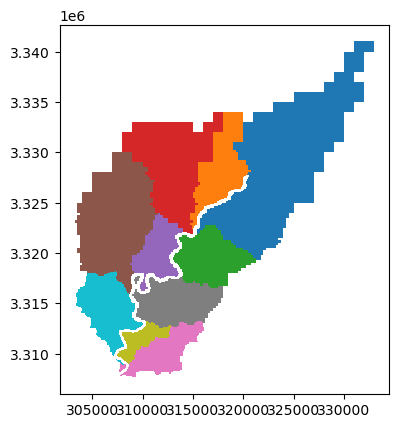

In [181]:
gpd_HruMap.plot( column='TargId' )

In [182]:
display( HTML( gpd_HruMap.describe().to_html() ) )

,iuzno,TopActive,SArea_m2,Weight,CellID,CombWeight
count,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000,10206.000000
mean,5676.351264,3.248089,43293.696723,11.911748,5863.607486,0.001176
std,3351.411736,1.001705,101360.873031,32.247287,3515.134090,0.002323
min,1.000000,1.000000,3906.250000,0.000000,5.000000,0.000067
25%,2737.250000,3.000000,15625.000000,0.100000,2793.250000,0.000413
50%,5706.500000,3.000000,15625.000000,0.100000,5828.500000,0.000486
75%,8568.750000,4.000000,62500.000000,0.100000,8780.750000,0.000997
max,11536.000000,6.000000,1000000.000000,100.000000,12341.000000,0.043529


In [183]:
OutFile = "cpPERLNDMap.shp"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
gpd_HruMap.to_file( OutFP )

## Springs or Drains

DRN boundaries are assumed to only be used to represent springs in the coupled model. Extract the DRN boundary information from our model and put it in the format required for the input dictionary.

Springs: springs which are represented with drain cells in the MODFLOW model are identified in this dictionary. The key is the TargID. Values are a list with a sublist for each drain cell, SL.
- SL[0]: boundary name
- SL[0]: NCPL, cell ID, 1-based
- SL[1]: "TopActive" top active layer (this is the remainder of the cell id), 1-based
- SL[2]: "SArea_m2" which holds the area of the cell for the Cell ID within the PERLND area

Definitions of drains for this coupled model.

In [184]:
# provides for location of all springs. Routed directly to a stream segment
DRN_Dict = { "finegan" : "Outside",
             "ud704" : "Outside",
             "ud703" : "Outside",
             "dolan" : "R005",
             "ud701" : "R005", }

Preliminary processing of drain package

In [185]:
drn = mf6.get_package( 'drn' )

In [186]:
exDRN = drn.stress_period_data.get_data()[0]

In [187]:
nOrgDRN = len( exDRN )
nOrgDRN

5

In [188]:
DrnHdrs = list( exDRN.dtype.names )
iCnt = 0
for tHdr in DrnHdrs:
    print("Index %d, %s" % (iCnt, tHdr) )
    iCnt += 1
# end for

Index 0, cellid
Index 1, elev
Index 2, cond
Index 3, boundname


In [189]:
DrnBndNames = list( set( list( exDRN[:][DrnHdrs[3]] ) ) )
len( DrnBndNames )

5

Setup of shapefiles to get areas

In [190]:
NumDRN = nOrgDRN

In [191]:
drcellids = exDRN['cellid'].view()
drnames = exDRN['boundname'].view()

In [192]:
#DRNfcIds = [ exDRN[iI][DrnHdrs[0]][1] for iI in range(nOrgDRN) ]
DRNfcIds = drcellids.tolist()
DRNCell2D = [ x[1] + 1 for x in DRNfcIds ]
DRNTA = [ x[0] + 1 for x in DRNfcIds ]
DRNNames = [ str(x) for x in drnames.tolist() ]
DRNNames

['finegan', 'ud704', 'ud703', 'dolan', 'ud701']

In [193]:
DRNCell2D

[9725, 11566, 11603, 11185, 11799]

In [194]:
DRNTA

[5, 6, 6, 6, 6]

In [195]:
gpd_DRN = gpd_Grid2D[gpd_Grid2D['CellID'].isin( DRNCell2D ) ].copy()
len( gpd_DRN )

5

In [196]:
V1Cols = list( gpd_DRN.columns )
V1Cols.remove("geometry")
display( HTML( gpd_DRN[V1Cols].to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight
9724,9725,5,-1,D,0,-1,15625.00,0.1
11184,11185,5,-1,D,0,10,3906.25,0.1
11565,11566,5,-1,D,0,-1,3906.25,0.1
11602,11603,5,-1,D,0,-1,3906.25,0.1
11798,11799,5,-1,D,0,8,3906.25,0.1


**Note**: all iuzno should be -1 because uzf cells should not be assigned where there are drn cells

CellID 11185 is Dolan Springs and CellID 11799 is adjacent to Dolan Springs. Both of these should discharge to Reach 5 rather than to the HRU. The other drains/springs are outside of the HSPF model domain.

In [197]:
exDRNIds = gpd_DRN['CellID'].tolist()

In [198]:
exDRNIds

[9725, 11185, 11566, 11603, 11799]

In [199]:
DRNCell2D

[9725, 11566, 11603, 11185, 11799]

In [200]:
exIuzno = gpd_DRN['iuzno'].tolist()
exTA = gpd_DRN["TopAct"].tolist()
exCellArea = gpd_DRN["CellArea_m2"].tolist()

In [201]:
exCellArea

[15625.0, 3906.25, 3906.25, 3906.25, 3906.25]

In [202]:
gpd_DRN["Label"] = "None"

In [203]:
gpd_DRN.at[DRNCell2D[0]-1, "Label"] = DRNNames[0]
gpd_DRN.at[DRNCell2D[1]-1, "Label"] = DRNNames[1]
gpd_DRN.at[DRNCell2D[2]-1, "Label"] = DRNNames[2]
gpd_DRN.at[DRNCell2D[3]-1, "Label"] = DRNNames[3]
gpd_DRN.at[DRNCell2D[4]-1, "Label"] = DRNNames[4]

In [204]:
gpd_DRN["DrnLayer"] = -1

In [205]:
gpd_DRN.at[DRNCell2D[0]-1, "DrnLayer"] = DRNTA[0]
gpd_DRN.at[DRNCell2D[1]-1, "DrnLayer"] = DRNTA[1]
gpd_DRN.at[DRNCell2D[2]-1, "DrnLayer"] = DRNTA[2]
gpd_DRN.at[DRNCell2D[3]-1, "DrnLayer"] = DRNTA[3]
gpd_DRN.at[DRNCell2D[4]-1, "DrnLayer"] = DRNTA[4]

In [206]:
V1Cols = list( gpd_DRN.columns )
V1Cols.remove("geometry")
display( HTML( gpd_DRN[V1Cols].to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,CellArea_m2,Weight,Label,DrnLayer
9724,9725,5,-1,D,0,-1,15625.00,0.1,finegan,5
11184,11185,5,-1,D,0,10,3906.25,0.1,dolan,6
11565,11566,5,-1,D,0,-1,3906.25,0.1,ud704,6
11602,11603,5,-1,D,0,-1,3906.25,0.1,ud703,6
11798,11799,5,-1,D,0,8,3906.25,0.1,ud701,6


In [207]:
OutFile = "DrnsSprings_Grid.shp"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
gpd_DRN.to_file( OutFP )

C:\Users\nmartin\AppData\Local\Temp\ipykernel_9016\2118996727.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd_DRN.to_file( OutFP )


Make the dictionary that will be serialized to defined linkages between MODFLOW 6 drain cells and HSPF.

In [208]:
SpringDict = dict()

In [209]:
for iI in range( nOrgDRN ):
    curLay = exDRN[iI][DrnHdrs[0]][0]
    curC2ID = exDRN[iI][DrnHdrs[0]][1]
    curBndName = exDRN[iI][DrnHdrs[3]]
    surfArea = float( gpd_DRN.at[curC2ID, "geometry"].area )
    #surfArea = float( MPolys.at[curC2ID, "geometry"].area )
    curHID = DRN_Dict[curBndName]
    if curHID in SpringDict.keys():
        SpringDict[curHID].append( [ curBndName, curC2ID+1, curLay+1, surfArea] )
    else:
        SpringDict[curHID] = [ [ curBndName, curC2ID+1, curLay+1, surfArea],]
    # end if
# end for

In [210]:
SpringDict

{'Outside': [['finegan', 9725, 5, 15625.0],
  ['ud704', 11566, 6, 3906.25],
  ['ud703', 11603, 6, 3906.25]],
 'R005': [['dolan', 11185, 6, 3906.25], ['ud701', 11799, 6, 3906.25]]}

In [211]:
OutFile = "cpWS_Springs.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( SpringDict, OP, pickle.HIGHEST_PROTOCOL )